In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/export/scratch1/home/grewal/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load meta csv and create df

In [2]:
root_dir = '/export/scratch2/bvdp/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split_preprocessed_21-08-2020/'
meta_path = "../meta/dataset_train_21-08-2020.csv"

results = {}
classes = ['background', 'bowel_bag', 'bladder', 'hip', 'rectum']

meta_df = pd.read_csv(meta_path)
# select data with all classes present
meta_df = meta_df[(meta_df[classes[1:]] >= 1).all(axis=1)].reset_index()
for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    np_filepath = f'{os.path.join(row.path, row.SeriesInstanceUID)}.npz'
    with np.load(np_filepath) as datapoint:
        vol, mask = datapoint['volume'], datapoint['mask_volume']
 
    n_slices = mask.shape[0]
    for cls, cls_idx in zip(classes, range(len(classes))):
        slices = np.where((mask == cls_idx).any(axis=(1,2)))[0]        
        slices_mask = pd.Series(slices >= 0, index=slices).reindex(range(n_slices)).fillna(False).values
        cls_results = results.get(cls, [])
        cls_results.append(slices_mask)
        results[cls] = cls_results


df = pd.DataFrame(results, index=meta_df.index) \
    .join(meta_df.drop(['bowel_bag', 'bladder', 'hip', 'rectum'], axis=1))
df.head(2)

100%|██████████| 186/186 [01:27<00:00,  2.13it/s]


,background,bowel_bag,bladder,hip,rectum,index,Modality,PatientPosition,PixelSpacing,RescaleIntercept,...,desired_slice_thickness,input_directory,labels,npixels,orientation,origin,path,root_path,patient_id,train
0,"[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1,CT,HFS,"[0.976562, 0.976562]",-1024.0,...,2.5,/export/scratch2/bvdp/Data/Projects_DICOM_data...,rectum|bladder|bowel_bag|hip,"[512, 512]",Transverse,"[-250.0, -250.0, 115.0]",/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,2636097697_3613183264,True
1,"[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2,CT,HFS,"[0.976562, 0.976562]",-1024.0,...,2.5,/export/scratch2/bvdp/Data/Projects_DICOM_data...,rectum|bladder|bowel_bag|hip,"[512, 512]",Transverse,"[-250.0, -250.0, 12.5]",/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,2636097697_3613183264,True


## Calculate size relative to hip

In [3]:
starts_ends = []
for cls in classes:
    start = df[cls].apply(pd.Series).apply(lambda x: x[x==1].index.min(), axis=1)
    end = df[cls].apply(pd.Series).apply(lambda x: x[x==1].index.max(), axis=1)
    size = end-start
    starts_ends.append(pd.DataFrame({f'{cls}_start': start, f'{cls}_end': end, f'{cls}_size': size}))

df_sizes = pd.concat(starts_ends, axis=1)
df_sizes.head()

,background_start,background_end,background_size,bowel_bag_start,bowel_bag_end,bowel_bag_size,bladder_start,bladder_end,bladder_size,hip_start,hip_end,hip_size,rectum_start,rectum_end,rectum_size
0,0,99,99,40.0,80.0,40.0,26.0,44.0,18.0,32.0,49.0,17.0,26.0,39.0,13.0
1,0,132,132,50.0,104.0,54.0,34.0,64.0,30.0,38.0,55.0,17.0,24.0,49.0,25.0
2,0,138,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,158,158,54.0,107.0,53.0,59.0,86.0,27.0,62.0,79.0,17.0,50.0,72.0,22.0
4,0,200,200,88.0,154.0,66.0,82.0,115.0,33.0,82.0,101.0,19.0,72.0,91.0,19.0


## Plot histogram for bowel bag and background

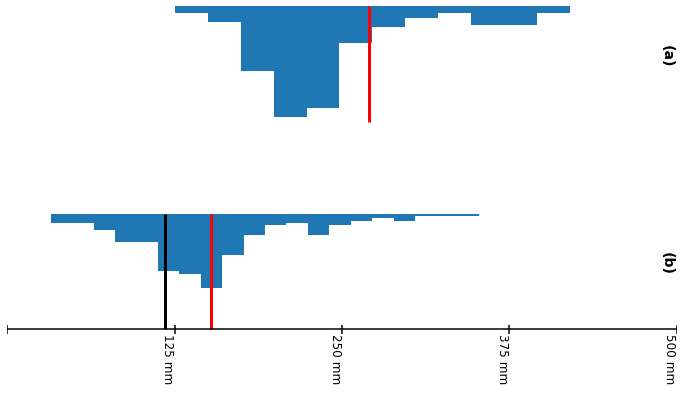

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12), sharex=True, sharey=True)

scans_end_rel_hip = (df_sizes['background_end'] - df_sizes.hip_end)
ax1 = axes.ravel()[0]
scans_end_rel_hip.plot.hist(bins=20, figsize=(12,7), ax=ax1)
ax1.vlines([108], ymin=0, ymax=50, color='red', linewidth=3)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 50)
# ax1.set_yticks([])
# ax1.set_ylabel("(a)", rotation=-90, labelpad=20, fontdict={"size":14, "weight":"bold"})
ax1.axis("off")
ax1.annotate("(a)", (195, 25), rotation=-90, fontsize=14, fontweight="demi")

bowel_bag_ends_rel_hip = (df_sizes['bowel_bag_end'] - df_sizes.hip_end)
ax2 = axes.ravel()[1]
bowel_bag_ends_rel_hip.plot.hist(bins=20, figsize=(12,7), ax=ax2)
# lower threshold
bb_stats = bowel_bag_ends_rel_hip.describe()
ax2.vlines([bb_stats['25%']], ymin=0, ymax=50, color='black', linewidth=3)
# upper threshold
ax2.vlines([61], ymin=0, ymax=50, color='red', linewidth=3)
# ax2.set_ylabel("(b)", rotation=-90, labelpad=20, fontdict={"size":14, "weight":"bold"})
# ax2.set_yticks([])
ax2.axis("off")
# plt.vlines([median, percentile_75], ymin=0, ymax=line_height, color='red')
ax1.set_xlim(0, 200)
ax2.set_ylim(0, 75)
ax2.invert_yaxis()
ax2.axhline(50, color="black")
ax2.vlines([0, 50, 100, 150, 200, 250], ymin=48, ymax=52, color="black")
ax2.annotate("0 mm", (0-4, 68), rotation=-90, fontsize=12)
ax2.annotate("125 mm", (50-4, 72), rotation=-90, fontsize=12)
ax2.annotate("250 mm", (100-4, 72), rotation=-90, fontsize=12)
ax2.annotate("375 mm", (150-4, 72), rotation=-90, fontsize=12)
ax2.annotate("500 mm", (200-4, 72), rotation=-90, fontsize=12)
ax2.annotate("625 mm", (250-4, 72), rotation=-90, fontsize=12)
ax2.annotate("(b)", (195, 25), rotation=-90, fontsize=14, fontweight="demi")

plt.savefig('../../outputs/histograms.png', dpi=300)

In [107]:
np.array([50, 100, 150, 200, 250]) * 2.5

array([125., 250., 375., 500., 625.])